### Michipicoten, Lake Superior 

**Station Name:** 	mchn

**Location:** Michipicoten Harbor, Ontario, Canada

**Archive:**  [SOPAC](http://sopac-csrc.ucsd.edu/index.php/sopac/) 

**Ellipsoidal Coordinates:**

- Latitude: 47.961

- Longitude: -84.901

- Height: 152.019 m

[Station Page at Natural Resources Canada](https://webapp.geod.nrcan.gc.ca/geod/data-donnees/station/report-rapport.php?id=M093001)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/MCHN.sta)

[Google Maps Link](https://goo.gl/maps/mU5GbsvMsLfe5buQ7) 

<p align=center>
<img src="../../../docs/_static/mchn_monu-cors.png" width="500"/>
</P>

In [1]:
import ipywidgets as widgets
import os

from pathlib import Path

from gnssrefl.utils import check_environment, set_environment, get_sys

notebook_dir = Path.cwd().parents[1]

# Making sure environment variables are set - this is required to run the gnssrefl code
exists = check_environment()
if exists == False:
    set_environment(refl_code=str(notebook_dir),
                    orbits=str(notebook_dir / "orbits"),
                    exe=str(notebook_dir / "exe"))
    
#If you are running this locally - make sure the items in the exe folder have execution permissions

# Set local variable of refl_code location
refl_code_loc = os.environ['REFL_CODE']
print("refl_code location:", refl_code_loc)

# import gnssrefl functions
from gnssrefl.installexe_cl import installexe
from gnssrefl.rinex2snr_cl import rinex2snr
from gnssrefl.quickLook_cl import quicklook
from gnssrefl.gnssir_cl import gnssir
from gnssrefl.gnssir_input import make_gnssir_input
from gnssrefl.daily_avg_cl import daily_avg


# import the crx2rnx file which is dependent on your working OS - this is required to run the gnssrefl code
# If in docker environment, then you do not need to download crxnrnx
try:
    os.environ['DOCKER']
except KeyError:
    sys = get_sys()
    installexe(sys)

environment variable ORBITS set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits 
environment variable REFL_CODE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks 
environment variable EXE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/exe
refl_code location: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks
Your executable environment area:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/exe
There is no teqc executable for this architecture, so none will be installed.
This Hatanaka executable already exists
The gfzrnx executable already exists


**Fast Mode:** 
this will download data weekly instead of daily

In [8]:
weekly = widgets.Checkbox(value=True, description='Fast Mode', disabled=False, indent=False)
weekly

Checkbox(value=True, description='Fast Mode', indent=False)

Deselect the Fast Mode checkbox to deactivate fast mode.

### Data Summary

Station mchn is operated by [NRCAN](https://www.nrcan.gc.ca/home).
The station overlooks Lake Superior in a favorable location for measuring seasonal water levels.
This site only tracks legacy GPS signals. 

More information on mchn can be obtained 
from the [GNSS-IR Web App](https://gnss-reflections.org/api?example=mchn),
where mchn is one of the test cases. 

For GNSS reflectometry, you need to set an azimuth and elevation angle mask.
The azimuths are chosen to ensure that the reflected signals reflect off the surface of interest.

Here is a good start on an elevation and azimuth angle mask:

In [3]:
%%html
<iframe src="https://gnss-reflections.org/rzones?station=mchn&msl=on&RH=7&eang=2&azim1=80&azim2=180" width="1000" height="600"></iframe>

### Take a quick look at the data

If you know where the data are stored (i.e. sopac), it is better (faster) to set that flag.
Since the receiver only tracks GPS signals, there is no need to specify gnss orbits.

In [4]:
# set variables so we can reuse them in other parts of the code
station = 'mchn'
rinex2snr(station, 2019, 205, archive='sopac')

mchn  year: 2019  doy: 205 from:  sopac
Requested a GPS only nav file
Nav file exists online
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2019/nav/auto2050.19n
ftp://garner.ucsd.edu/pub/rinex/2019/205/mchn2050.19d.Z
100% [............................................................................] 353837 / 353837
 File has been found  mchn2050.19d.Z


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2019/snr/mchn/mchn2050.19.snr66
That took  1.46  seconds
Feedback written to subdirectory logs


Examine the spectral characteristics of the SNR data for the default settings
[(For details on quickLook output.)](../../docs/quickLook_desc.md):

minimum elevation angle (degrees) for this dataset:  0.1613
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/quickLook_summary.png


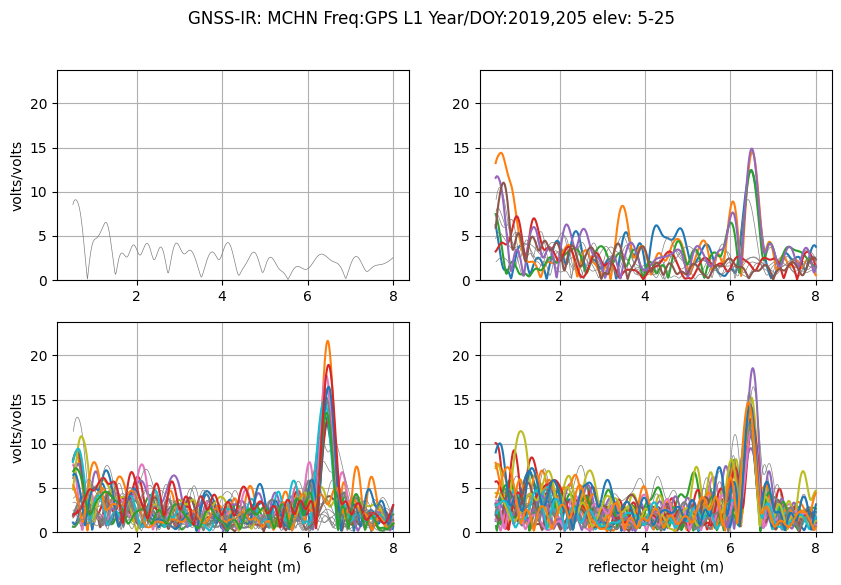

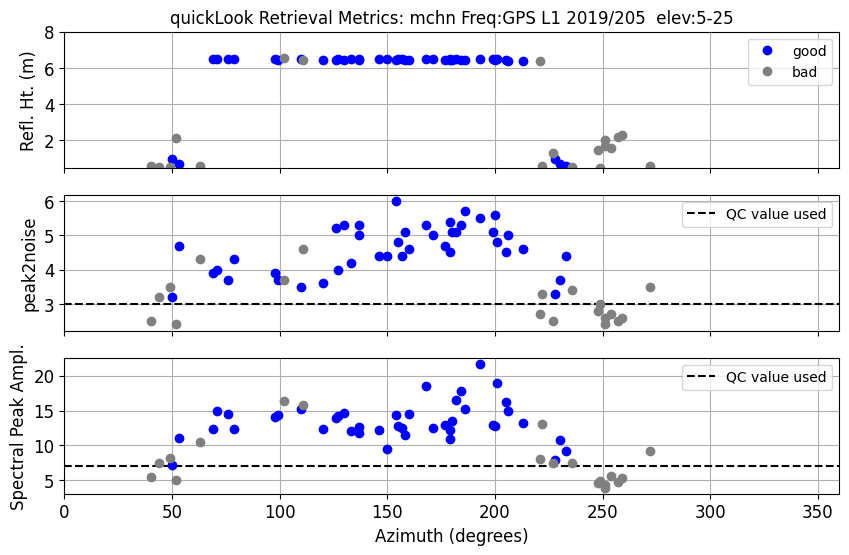

In [5]:
values, metrics = quicklook(station, 2019, 205)

When we run quicklook, there are several default values that do not work for every station.

You can see the default values by running the following cell:

In [ ]:
quicklook?

We can clean this up a little bit by setting the minimum reflector height to 2 for `quickLook`:

minimum elevation angle (degrees) for this dataset:  0.1613
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/quickLook_summary.png


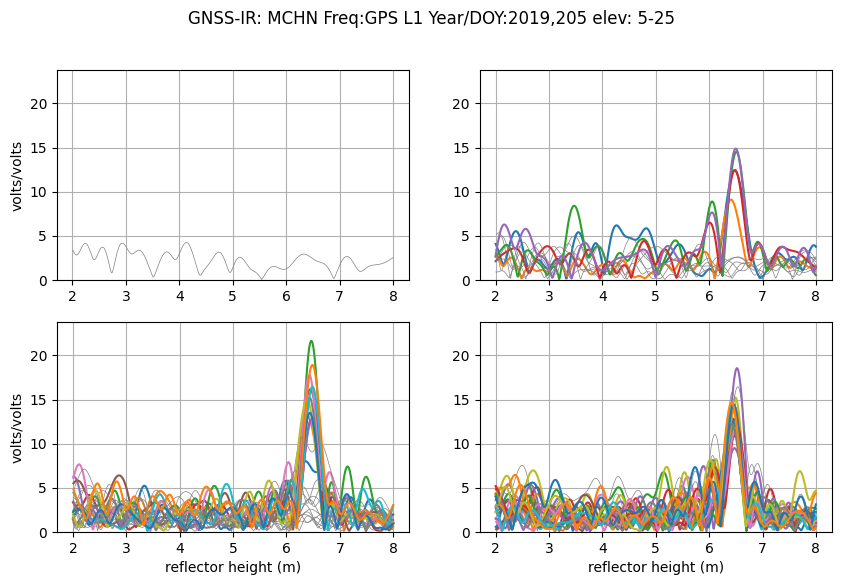

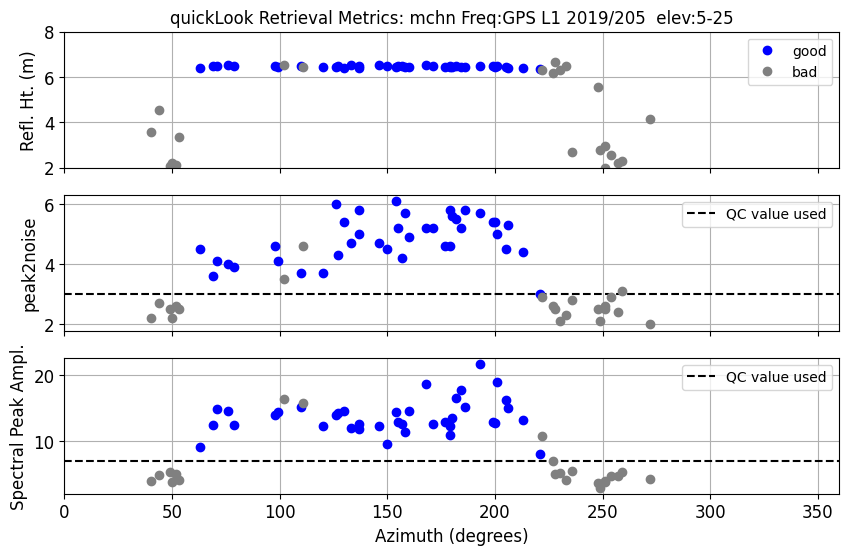

In [6]:
vals, metrics = quicklook(station, 2019, 205, h1=2)

The water is ~6.5 meters below the antenna. You can see from the top plot that the good retrievals (in blue) 
very clearly show you which azimuths are acceptable and which are not.  The middle plot shows the peak to noise 
ratio, which we would like to at least exceed 3. And here again, the bad retrievals are always below this level.
The amplitudes in the bottom plot indicate that 8 is an acceptable minimal value.


### Analyze the Data

The data from 2013 will be analyzed here as a test case.  Begin by generating the SNR files.

In [9]:
year = 2013
doy = 1
doy_end = 365

rinex2snr(station, year, doy, doy_end=doy_end, archive='sopac', weekly=weekly.value)

You have invoked the weekly option
mchn  year: 2013  doy: 1 from:  sopac
Requested a GPS only nav file
100% [..............................................................................] 74537 / 74537found nav file at SOPAC
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2013/nav/auto0010.13n
ftp://garner.ucsd.edu/pub/rinex/2013/001/mchn0010.13d.Z
100% [............................................................................] 389135 / 389135
 File has been found  mchn0010.13d.Z


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2013/snr/mchn/mchn0010.13.snr66
mchn  year: 2013  doy: 8 from:  sopac
Requested a GPS only nav file
100% [..............................................................................] 75533 / 75533found nav file at SOPAC
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2013/nav/auto0080.13n
ftp://garner.ucsd.edu/pub/rinex/2013/008/mchn0080.13d.Z
100% [......................

Analysis parameters are set up with <code>make_gnssir_input</code>

In [11]:
make_gnssir_input(station, h1=3, h2=10, l1=True, peak2noise=3, ampl=8, azlist2=[80, 180])

Assume you want to use the UNR database.
Using standard frequency choices.
writing out to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/mchn.json


While most of the analysis settings can be done by the command 
line, you can see that the azimuths have been set by
hand to be limited to 80-180 degrees. Although it is possible to get good reflections beyond 
180 degrees, the photographs suggest barriers are present in that region. 

Now that the analysis parameters are set, run <code>gnssir</code> to save the reflector height (RH) output for each day in 2013.

In [12]:
gnssir(station, year, doy, doy_end=doy_end)

{'station': 'mchn', 'lat': 47.961335362, 'lon': -84.900853197, 'ht': 152.0190422, 'minH': 3, 'maxH': 10, 'e1': 5.0, 'e2': 25.0, 'NReg': [3, 10], 'PkNoise': 3, 'polyV': 4, 'pele': [5, 30], 'ediff': 2.0, 'desiredP': 0.005, 'azval2': [80, 180], 'freqs': [1], 'reqAmp': [8], 'refraction': True, 'overwriteResults': True, 'seekRinex': False, 'wantCompression': False, 'plt_screen': False, 'onesat': None, 'screenstats': False, 'pltname': 'mchn_lsp.png', 'delTmax': 75.0, 'gzip': False, 'ellist': []}
refraction file exists
requested frequencies  [1]
Using the New Way of Selecting Arcs
Augmented elevation angle list []
Requested azimuths:  [80, 180]
Using azimuths:  [80, 180]
A station specific refraction output file will be written to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/mchn_refr.txt
found  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/
The large refraction file should be stored here: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/gpt_1wA.pickle
1st a

You can optionally see lots of SNR data with the plt=True option.

{'station': 'mchn', 'lat': 47.961335362, 'lon': -84.900853197, 'ht': 152.0190422, 'minH': 3, 'maxH': 10, 'e1': 5.0, 'e2': 25.0, 'NReg': [3, 10], 'PkNoise': 3, 'polyV': 4, 'pele': [5, 30], 'ediff': 2.0, 'desiredP': 0.005, 'azval2': [80, 180], 'freqs': [1], 'reqAmp': [8], 'refraction': True, 'overwriteResults': True, 'seekRinex': False, 'wantCompression': False, 'plt_screen': False, 'onesat': None, 'screenstats': False, 'pltname': 'mchn_lsp.png', 'delTmax': 75.0, 'gzip': False, 'ellist': []}
refraction file exists
requested frequencies  [1]
Using the New Way of Selecting Arcs
Augmented elevation angle list []
Requested azimuths:  [80, 180]
Using azimuths:  [80, 180]
Refraction parameters  992.2871857033224 5.506376704849698 1
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2013/snr/mchn/mchn1970.13.snr66
Results will be written to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2013/results/mchn//197.txt
data found for this frequency:  1


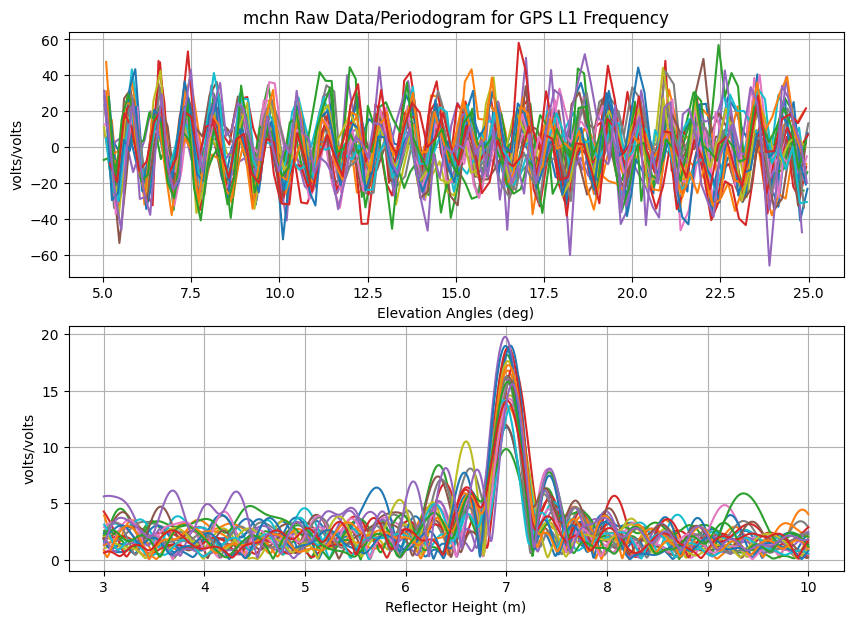

In [14]:
gnssir(station, year, 197, plt=True)

For a lake, it is appropriate to use the daily average. Our utility for computing a daily average requires a value
for the median filter and a minimum number of tracks. If the median value is set to be large (2 meters), you can see 
large outliers: 

All RH retrievals - including bad ones - will be written to: 
/Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_allRH.txt.noqc 

All RH retrievals that meet your median filter and ReqTracks criteria will be written to: 
/Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_allRH.txt 

A total of  50  days were evaluated.
2  days did not meet the threshold set for a dependable daily average
All RH png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_AllRH.png
All RH png file without QC saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_AllRH_noQC.png
Daily average RH png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_RH.png
Daily average RH amplitude file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_RHamp.png
Number of values used in average RH file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/m

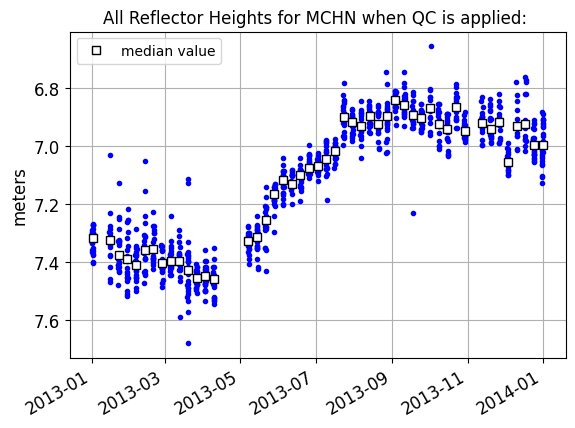

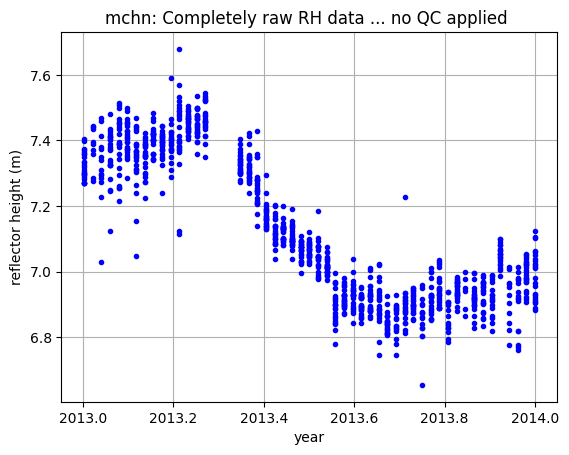

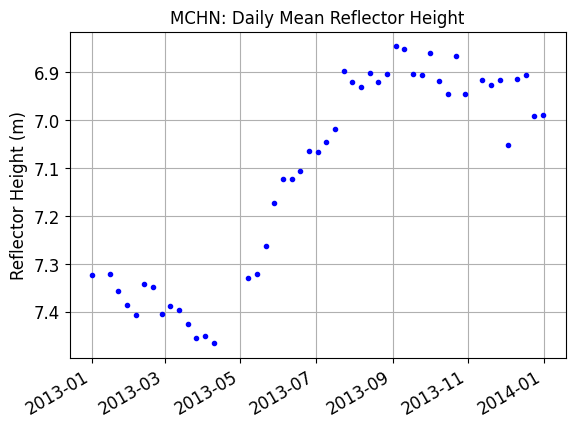

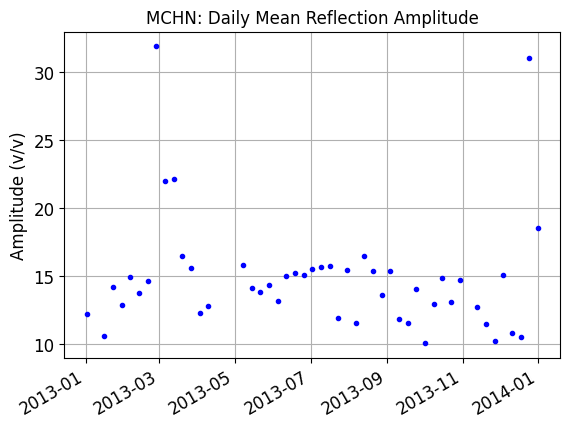

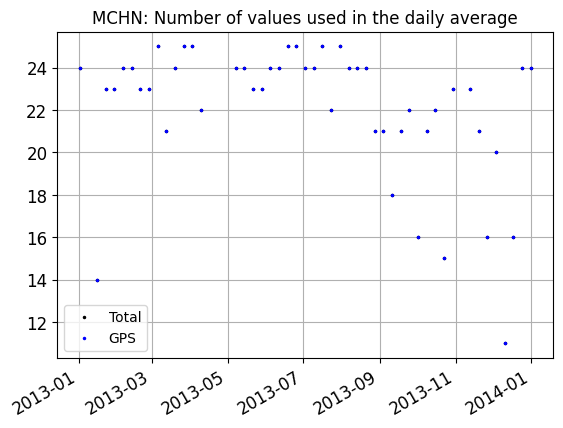


Daily average RH file written to:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_dailyRH.txt


In [15]:
daily_avg(station, 2, 10)

A more reasonable result is obtained with a 0.25-meter median filter and the 12-track requirement. If you want to save 
the daily averages to a specific file, use the txtfile= option. Otherwise it will use a default location (which is printed to the screen)

All RH retrievals - including bad ones - will be written to: 
/Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_allRH.txt.noqc 

All RH retrievals that meet your median filter and ReqTracks criteria will be written to: 
/Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_allRH.txt 

A total of  50  days were evaluated.
3  days did not meet the threshold set for a dependable daily average
All RH png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_AllRH.png
All RH png file without QC saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_AllRH_noQC.png
Daily average RH png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_RH.png
Daily average RH amplitude file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn_RHamp.png
Number of values used in average RH file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/m

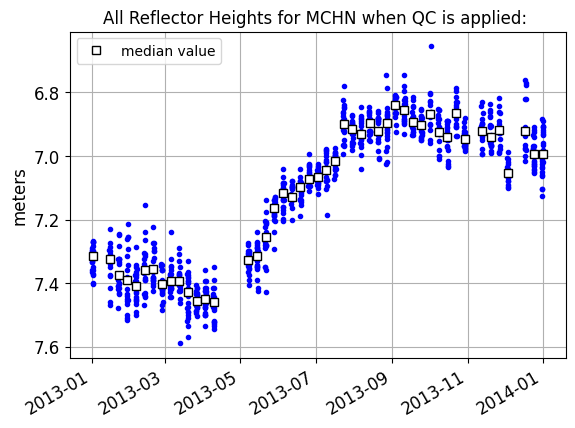

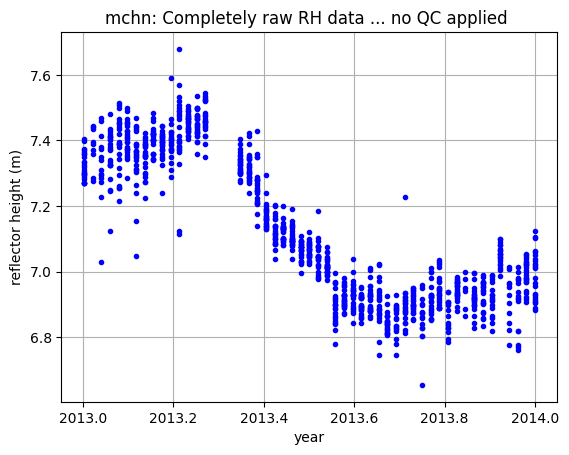

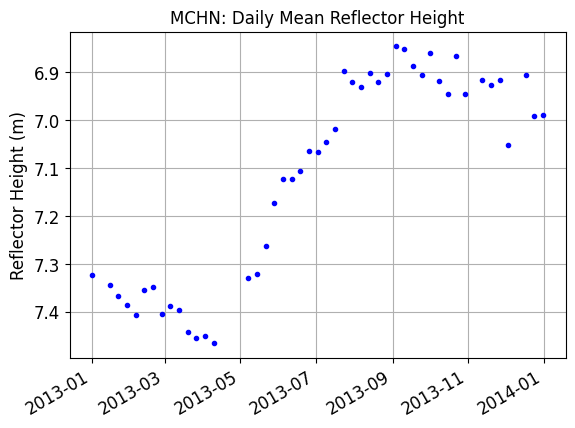

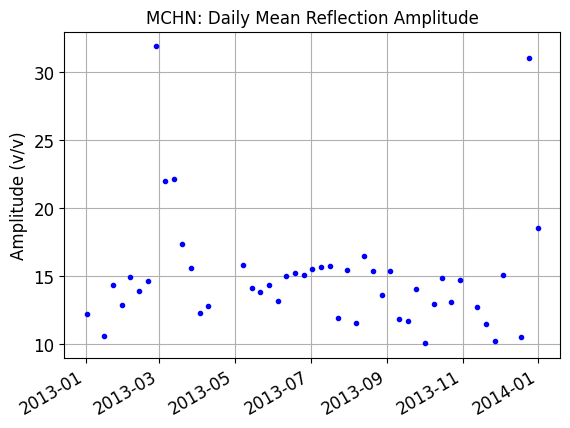

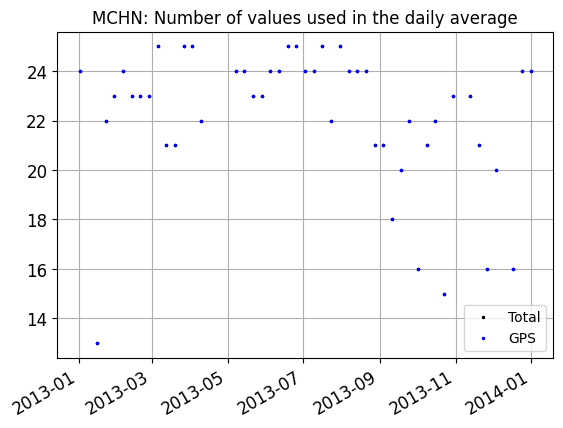


Daily average RH file written to:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/mchn/mchn-dailyavg.txt


In [17]:
daily_avg(station, 0.25, 12, txtfile='mchn-dailyavg.txt')

The number of tracks required will depend on the site. Here the azimuth is restricted because  of the location of the antenna.
Please note that these reflections are from ice in the winter and water during the summer. Surface 
bias corrections (ice, snow) will be implemented in the software in the future. Until then, please take 
this into account when interpreting the results.

There is a [tide gauge](https://tides.gc.ca/eng/Station/Month?sid=10750) at this site. The data can be 
downloaded from [this link](http://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/interval-intervalle-eng.asp?user=isdm-gdsi&region=CA&tst=1&no=10750). 
Please select the daily mean water level, as there are restrictions on hourly data (more information is available on the download page). 
We have downloaded [the 2013 data](../../../data/10750-01-JAN-2013_slev.csv).

The water levels measured by the traditional tide gauge and GNSS-IR are shown here:

In [31]:
#code copied from plotmchn.py in gnssrefl use_cases
import re
from datetime import datetime, timedelta
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def readfiles(tide_file, rh_file):
    tidedates=[]
    waterlevel=[]
    mchndates=[]
    reflht=[]
    tide_regex = '(?P<date>^[\d|-]+),(?P<slev>[-|\d|.]*),'
    rh_regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'

#read tide data    
    with open(tide_file, 'r') as my_tide_file:
        tide_data = my_tide_file.read()
        tide_matches = re.finditer(tide_regex, tide_data, flags=re.MULTILINE)        
    for tide_match in tide_matches:
        tidedates.append(datetime.strptime(tide_match.group('date'), '%Y-%m-%d'))
        waterlevel.append(float(tide_match.group('slev')))

#read daily average reflector heights
    with open(rh_file, 'r') as my_rh_file:
        rh_data = my_rh_file.read()
        rh_matches = re.finditer(rh_regex, rh_data, flags=re.MULTILINE)        
        for rh_match in rh_matches:
            ydoy = f'{int(rh_match.group("year"))}-{int(rh_match.group("doy"))}'
            date = datetime.strptime(ydoy, '%Y-%j')
            mchndates.append(date)
            reflht.append(float(rh_match.group('rh')))    
    return tidedates, waterlevel, mchndates, reflht

#both tidegauge and gps data sets have gaps, so pad the missing days with nan (also generate date vector list for full year)
def addnans(ymdvec, datavec):
    yearvec=[]
    paddedvec=[]
    date1 = datetime.fromisoformat('2013-01-01')
    date2 = datetime.fromisoformat('2013-12-31')
    ct_day = date1    
    for day in range(0, 365):
        yearvec.append(ct_day)
        ct_day = ct_day + timedelta(days=1)    
    tmp = math.nan
    for i in range(0, len(yearvec)):
        for j in range(0, len(ymdvec)):
            if yearvec[i] == ymdvec[j]:
                tmp = datavec[j]
        paddedvec.append(tmp)
        tmp = math.nan    
    return yearvec, paddedvec

def getrms(residuals):
    val = np.sqrt((residuals**2).mean())
    return val


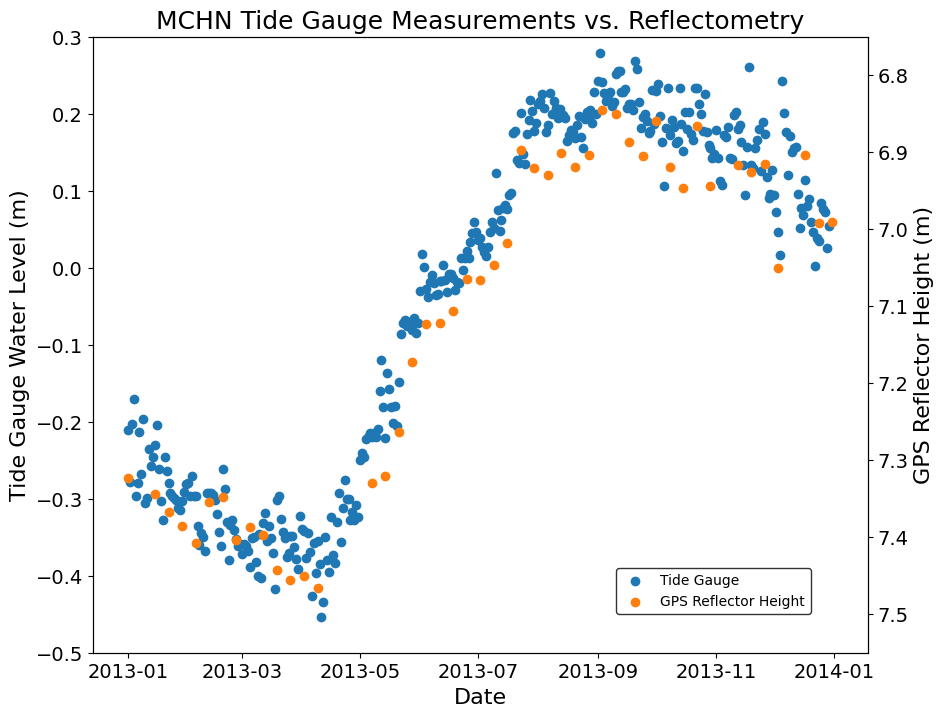

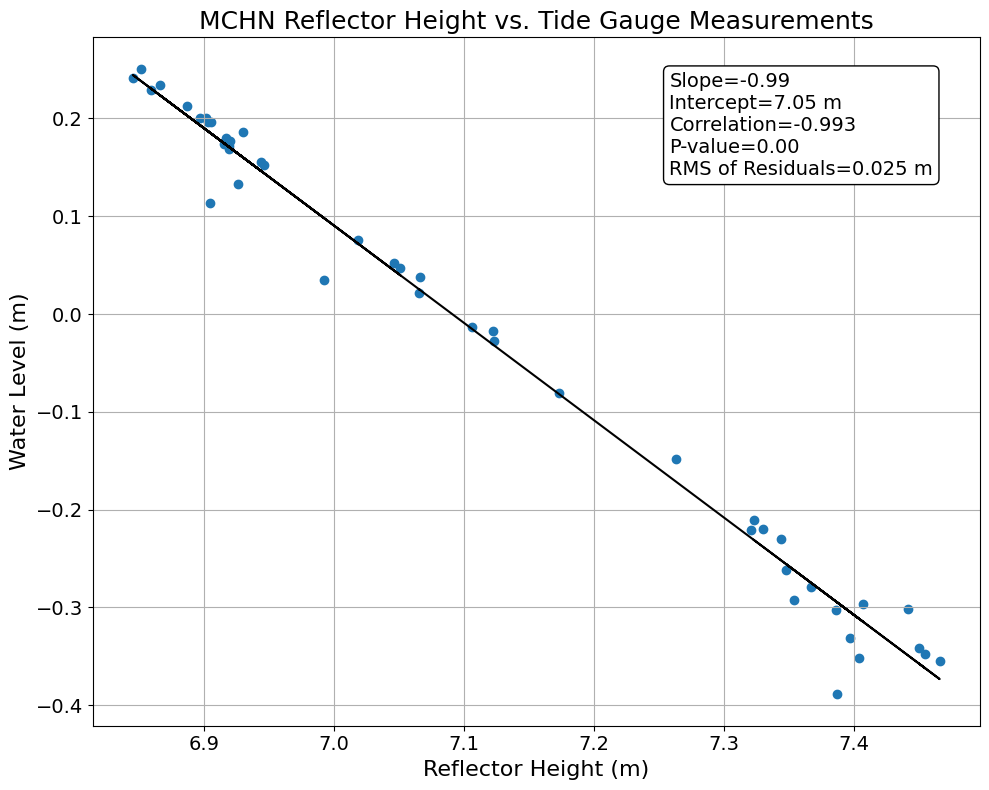

In [54]:
tidedates, waterlevel, mchndates, reflht = readfiles(tide_file='../../../docs/use_cases/10750-01-JAN-2013_slev.csv', 
                                                                         rh_file=f'{refl_code_loc}/Files/{station}/{station}-dailyavg.txt')
#pad missing days with nan
ymd, padded_rh = addnans(mchndates, reflht)
ymd, padded_wl = addnans(tidedates, waterlevel)    

#create numpy array objects
rh_array = np.array(padded_rh)
wl_array = np.array(padded_wl)    

#get linear regression (use scipy but mask out nans)
mask = ~np.isnan(rh_array) & ~np.isnan(wl_array)    
slope, intercept, r_val, p_val, std_err = stats.linregress(rh_array[mask], wl_array[mask])
checkfit = slope*rh_array[mask] + intercept    
resids = [i - j for i, j in zip(wl_array[mask], checkfit)]
resids_array = np.array(resids)
rms_resids = getrms(resids_array)

#plot time series for the water levels and reflector heights (with reversed axes)    
fig, ax1 = plt.subplots(figsize=(10, 8))
color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Tide Gauge Water Level (m)', color='black', fontsize=16)
ax1.scatter(tidedates, waterlevel, label='Tide Gauge', color=color)
ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
ax1.tick_params(axis='x', labelcolor='black', labelsize=14)
plt.ylim(-.5,.3)    

#instantiate a second axes that shares the same x-axis    
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('GPS Reflector Height (m)', color='black', fontsize=16)  
#we already handled the x-label with ax1
ax2.scatter(mchndates, reflht, label='GPS Reflector Height', color=color)
ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
plt.ylim(6.75,7.55)
plt.gca().invert_yaxis()
plt.title('MCHN Tide Gauge Measurements vs. Reflectometry', fontsize=18)    

fig.legend(loc='lower right', bbox_to_anchor=(.85, 0.15), edgecolor='black')

#plot reflector height vs. water level (using masked values)    
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(rh_array[mask], checkfit, '-', color='black')
ax.scatter(rh_array[mask], wl_array[mask], color = 'tab:blue')    
ax.set_xlabel("Reflector Height (m)", fontsize=16)
ax.set_ylabel("Water Level (m)", fontsize=16)
ax.set_title('MCHN Reflector Height vs. Tide Gauge Measurements', fontsize=18)
ax.tick_params(labelsize=14)
plt.grid()
txtstr = '\n'.join((
    'Slope=%.2f' % (slope, ),
    'Intercept=%.2f m' % (intercept, ),
    'Correlation=%.3f' % (r_val, ),
    'P-value=%.2f' % (p_val, ),
    'RMS of Residuals=%.3f m' % (rms_resids, )))
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(.65, .95, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
fig.tight_layout()
plt.show()

The linear regression between the two series gives a slope m=-1.02. The rms of the residuals is very good, 0.026 m.

### Reference

DFO (2021). Institute of Ocean Sciences Data Archive. Ocean Sciences Division. Department of Fisheries and Oceans 
Canada. http://www.pac.dfo-mpo.gc.ca/science/oceans/data-donnees/index-eng.html. Data obtained on 2021-01-28.